from https://github.com/ritchie46/vanilla-machine-learning

In [3]:
import torch
import torch.distributions as dist
from torch import nn
# from torchvision import datasets, transforms
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class Planar(nn.Module):
    def __init__(self, size=1, init_sigma=0.01):
        super().__init__()
        self.u = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.w = nn.Parameter(torch.randn(1, size).normal_(0, init_sigma))
        self.b = nn.Parameter(torch.zeros(1))

    @property
    def normalized_u(self):
        """
        Needed for invertibility condition.

        See Appendix A.1
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """

        # softplus
        def m(x):
            return -1 + torch.log(1 + torch.exp(x))

        wtu = torch.matmul(self.w, self.u.t())
        w_div_w2 = self.w / torch.norm(self.w)
        return self.u + (m(wtu) - wtu) * w_div_w2

    def psi(self, z):
        """
        ψ(z) =h′(w^tz+b)w

        See eq(11)
        Rezende et al. Variational Inference with Normalizing Flows
        https://arxiv.org/pdf/1505.05770.pdf
        """
        return self.h_prime(z @ self.w.t() + self.b) @ self.w

    def h(self, x):
        return torch.tanh(x)

    def h_prime(self, z):
        return 1 - torch.tanh(z) ** 2

    def forward(self, z):
        if isinstance(z, tuple):
            z, accumulating_ldj = z
        else:
            z, accumulating_ldj = z, 0
        psi = self.psi(z)

        u = self.normalized_u

        # determinant of jacobian
        det = (1 + psi @ u.t())

        # log |det Jac|
        ldj = torch.log(torch.abs(det) + 1e-6)

        wzb = z @ self.w.t() + self.b

        fz = z + (u * self.h(wzb))

        return fz, ldj + accumulating_ldj

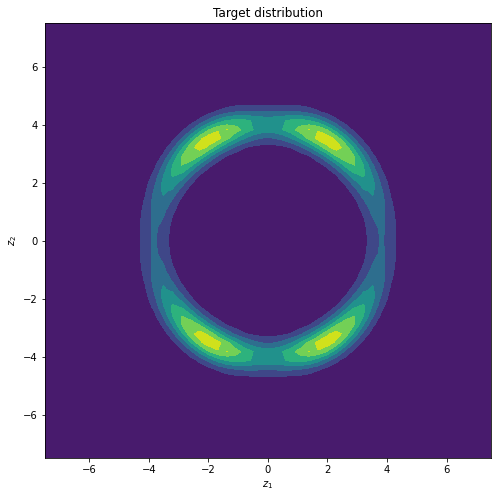

In [5]:
def target_density(z):
    z1, z2 = z[..., 0], z[..., 1]
    norm = (z1**2 + z2**2)**0.5
    exp1 = torch.exp(-0.2 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.2 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

x1 = np.linspace(-7.5, 7.5)
x2 = np.linspace(-7.5, 7.5)
x1_s, x2_s = np.meshgrid(x1, x2)
x_field = np.concatenate([x1_s[..., None], x2_s[..., None]], axis=-1)
x_field = torch.tensor(x_field, dtype=torch.float)

plt.figure(figsize=(8, 8))
plt.title("Target distribution")
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.contourf(x1_s, x2_s, target_density(x_field))
plt.show()

In [6]:
def det_loss(mu, log_var, z_0, z_k, ldj, beta):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    # P(x|z)
    nll = -torch.log(target_density(z_k) + 1e-7).sum() * beta
    return (log_qzk + nll) / batch_size

In [7]:
def train_flow(flow, shape, epochs=1000):
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)

    for i in range(epochs):
        z0, zk, ldj, mu, log_var = flow(shape=shape)
        loss = det_loss(mu=mu,
                        log_var=log_var,
                        z_0=z0,
                        z_k=zk,
                        ldj=ldj,
                        beta=1)
        loss.backward()
        optim.step()
        optim.zero_grad()
        if i % 250 == 0:
            print(loss.item())


In [8]:
class Flow(nn.Module):
    def __init__(self, dim=2, n_flows=10):
        super().__init__()
        self.flow = nn.Sequential(*[
            Planar(dim) for _ in range(n_flows)
        ])
        self.mu = nn.Parameter(torch.randn(dim, ).normal_(0, 0.01))
        self.log_var = nn.Parameter(torch.randn(dim, ).normal_(1, 0.01))

    def forward(self, shape):
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn(shape)  # unit gaussian
        z0 = self.mu + eps * std

        zk, ldj = self.flow(z0)
        return z0, zk, ldj, self.mu, self.log_var

In [11]:
def show_samples(s0, sk, mu, title):
    
    alpha = 0.2
    
    mask_1 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] > mu[1])
    mask_2 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] < mu[1])
    mask_3 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] > mu[1])
    mask_4 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] < mu[1])
    
    for s, title in zip([s0, sk], ['Base distribution $z_0$', title]):
        plt.figure(figsize=(8, 8))
        plt.title(title)
        plt.scatter(s[:, 0][mask_1], s[:, 1][mask_1], color='C0', alpha=alpha)
        plt.scatter(s[:, 0][mask_2], s[:, 1][mask_2], color='C1', alpha=alpha)
        plt.scatter(s[:, 0][mask_3], s[:, 1][mask_3], color='C3', alpha=alpha)
        plt.scatter(s[:, 0][mask_4], s[:, 1][mask_4], color='C4', alpha=alpha)

        plt.xlim(-7.5, 7.5)
        plt.ylim(-7.5, 7.5)
        plt.show()

6.8326921463012695
-0.2571013271808624
-1.1677138805389404
-1.2513041496276855
-1.1690768003463745
-1.2846333980560303
-1.222421407699585
-1.2414250373840332
-1.2020103931427002
-1.219066858291626
-1.2095688581466675
-1.2757247686386108
-1.6504143476486206
-1.68642258644104
-1.6277978420257568
-1.6769887208938599
-1.6704870462417603
-1.6962538957595825
-1.6921240091323853
-1.7114559412002563


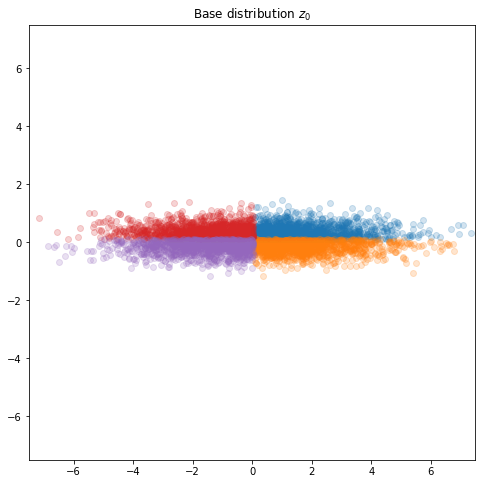

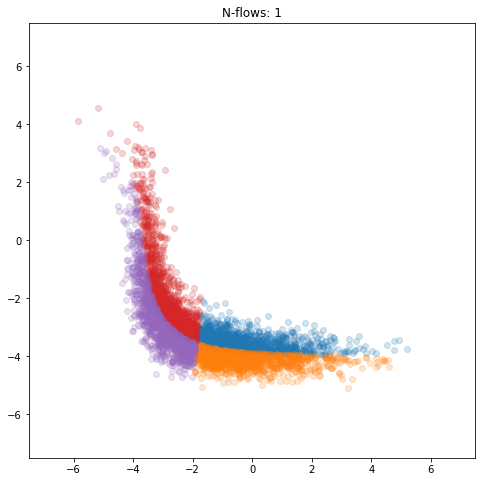

6.935564041137695
-1.5966057777404785
-1.7616215944290161
-2.011080265045166
-2.1027979850769043
-2.108095169067383
-2.143963098526001
-2.1910791397094727
-2.1464767456054688
-2.158672332763672
-2.226745843887329
-2.271233081817627
-2.2842743396759033
-2.2595884799957275
-2.3078720569610596
-2.300849199295044
-2.3506224155426025
-2.3281469345092773
-2.3554530143737793
-2.3434910774230957


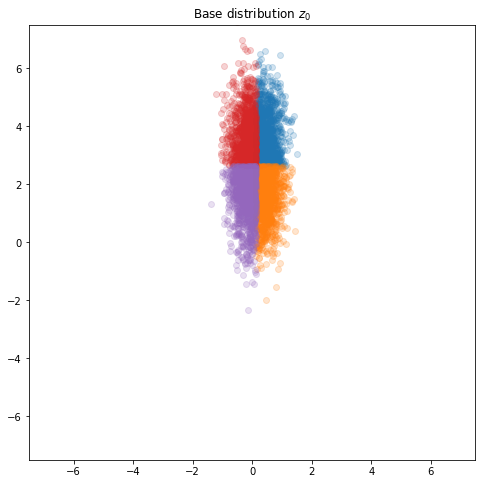

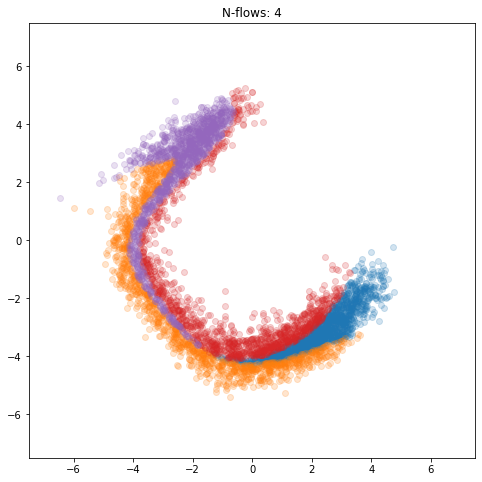

6.981918811798096
-1.6040009260177612
-1.9679886102676392
-2.0739572048187256
-2.1401119232177734
-2.157125949859619
-2.2815346717834473
-2.435628890991211
-2.4783847332000732
-2.529806137084961
-2.528804302215576
-2.5421104431152344
-2.5656330585479736
-2.5498409271240234
-2.564326286315918
-2.558492422103882
-2.5696849822998047
-2.596599817276001
-2.590613842010498
-2.573089361190796


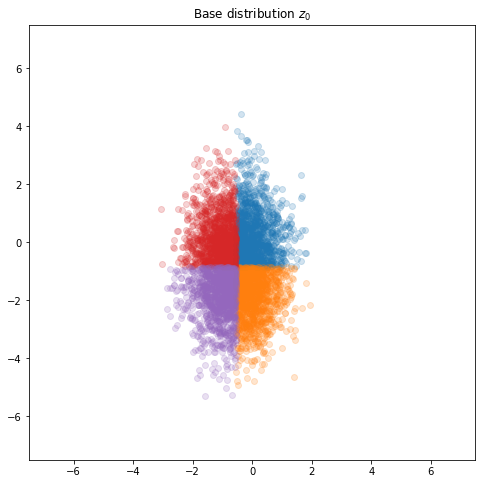

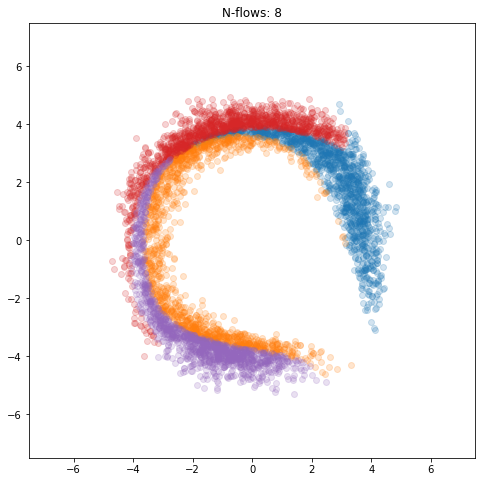

6.838965892791748
-1.6605613231658936
-2.027952194213867
-2.1539151668548584
-2.281176805496216
-2.4851224422454834
-2.543111801147461
-2.598933696746826
-2.631291389465332
-2.626519203186035
-2.6702001094818115
-2.671254873275757
-2.719269275665283
-2.6855854988098145
-2.713385820388794
-2.699402093887329
-2.7086782455444336
-2.714293956756592
-2.712355852127075
-2.7135121822357178


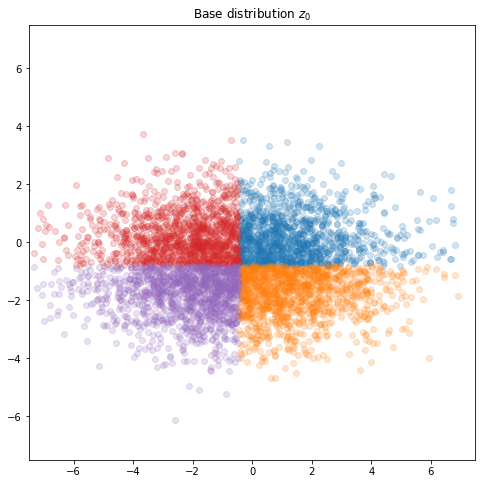

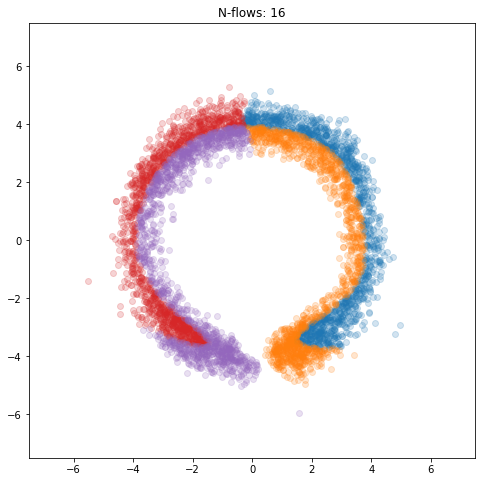

In [10]:
for n_flows in [1, 4, 8, 16]:
    flow = Flow(dim=2, n_flows=n_flows)
    shape = (1000, 2)
    train_flow(flow, shape, epochs=5000)
    z0, zk, ldj, mu, log_var = flow((5000, 2))
    show_samples(z0.data, zk.data, mu, f"N-flows: {n_flows}")
